In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import importlib
import dataReading 
from scipy.optimize import minimize
from functools import partial
from scipy.stats import norm, t
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm
import seaborn as sns

In [2]:
# # How to load all functions from a file into the notebook
# importlib.reload(dataReading) # Needed so that you dont need to reload kernel when changing function
# from dataReading import *

## 1. Explore the weekly data set (market_data.csv) 
- a) Plot the evolution of the stocks and the interest rates over the period 1996-01-01 -> 2023-12-31, in 
two separate plots (with legends). Normalize all the stock prices so that they have an initial price of 100 
enabling a fair comparison of their performances. Do not normalize the rates. 
- b) Determine for each stock (and present in a table):  
• the annualized mean log-return,   
• the annualized volatility of log-returns,  
• the 5th and the 95th log-return percentiles, and 
• the minimum and maximum log-return.  
- c) Determine the correlation matrix for the log-returns of all stocks and interest rates and plot as a 
heatmap, together with the values formatted as percent. 

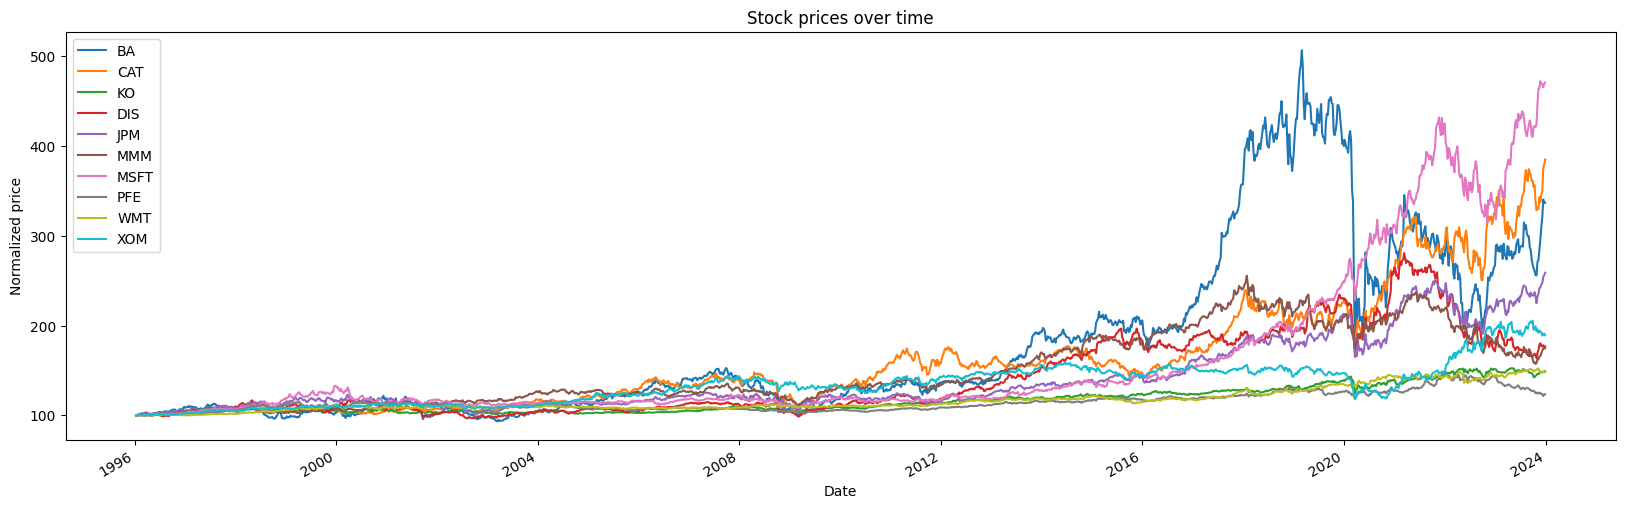

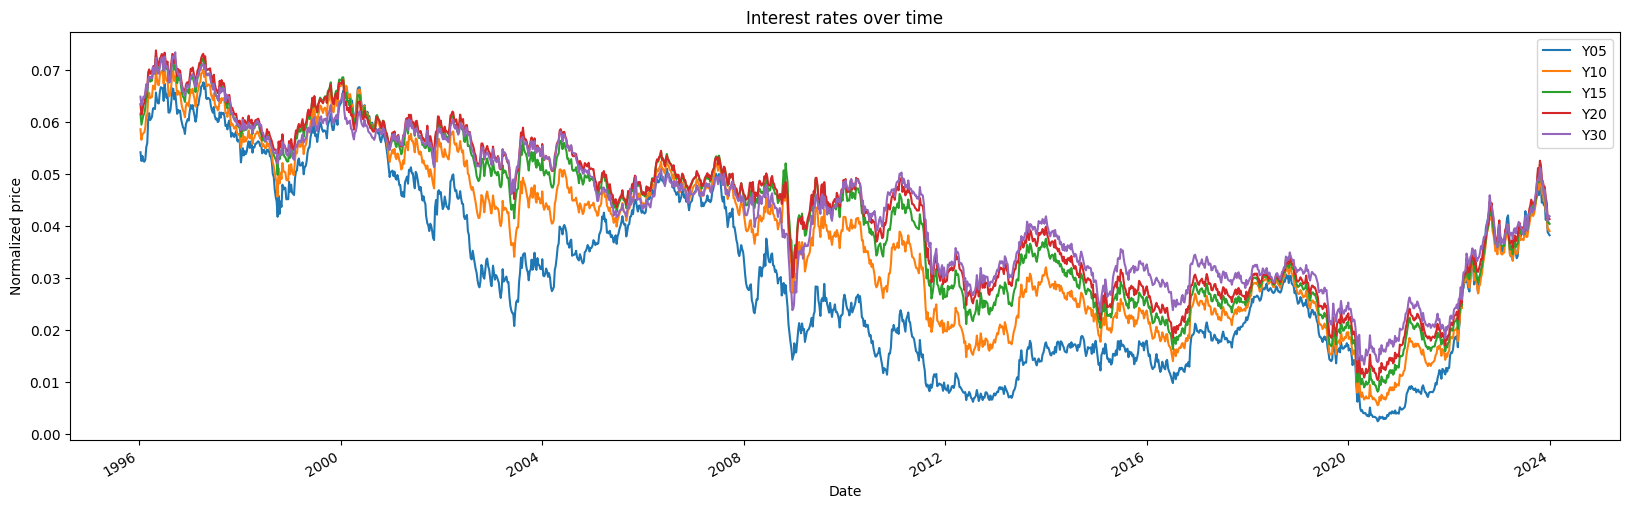

In [3]:
## a
marketDataDf = pd.read_csv('market_data.csv', sep=';', parse_dates=True, index_col='Date')
StockDF = marketDataDf.iloc[:,:10].copy()
RatesDF = marketDataDf.iloc[:,10:].copy()

InitialValue = StockDF.iloc[0]
normalizedDf = (100 - InitialValue) + StockDF
AllAssetsDf = pd.concat([normalizedDf,RatesDF], axis=1)

normalizedDf.plot(figsize=(20,6), title = 'Stock prices over time', ylabel='Normalized price');
RatesDF.plot(figsize=(20,6), title = 'Interest rates over time', ylabel='Normalized price');


In [4]:
## b
stockReturnDf = np.log(StockDF).diff()
stockReturnDf = stockReturnDf.dropna()

meanLogReturn = stockReturnDf.mean() * 250
volatilityLogReturns = stockReturnDf.std() * np.sqrt(250)
lowerPercentile = stockReturnDf.quantile(0.05)
upperPercentile = stockReturnDf.quantile(0.95)
minimum = stockReturnDf.min()
maximum = stockReturnDf.max()

TableDf = pd.DataFrame(columns=stockReturnDf.columns)
TableDf.loc['Mean Log Return'] = meanLogReturn
TableDf.loc['Volatility Log Returns'] = volatilityLogReturns
TableDf.loc['5th Percentile'] = lowerPercentile
TableDf.loc['95th Percentile'] = upperPercentile
TableDf.loc['Minimum'] = minimum
TableDf.loc['Maximum'] = maximum


TableDf

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM
Mean Log Return,0.409276,0.637213,0.322325,0.307541,0.514701,0.344627,0.809750,0.334798,0.531562,0.423777
Volatility Log Returns,0.833350,0.719112,0.490862,0.619653,0.787666,0.513228,0.627998,0.561350,0.531959,0.531640
5th Percentile,-0.072979,-0.072514,-0.045274,-0.060455,-0.075834,-0.054422,-0.058759,-0.051922,-0.051592,-0.052012
95th Percentile,0.072263,0.076259,0.047819,0.064185,0.071254,0.051068,0.068038,0.058124,0.053755,0.053587
Minimum,-0.582992,-0.224978,-0.236452,-0.248513,-0.416844,-0.174427,-0.211151,-0.227099,-0.216747,-0.223982
Maximum,0.533614,0.269244,0.111502,0.163325,0.399379,0.160226,0.209799,0.133070,0.167702,0.154747


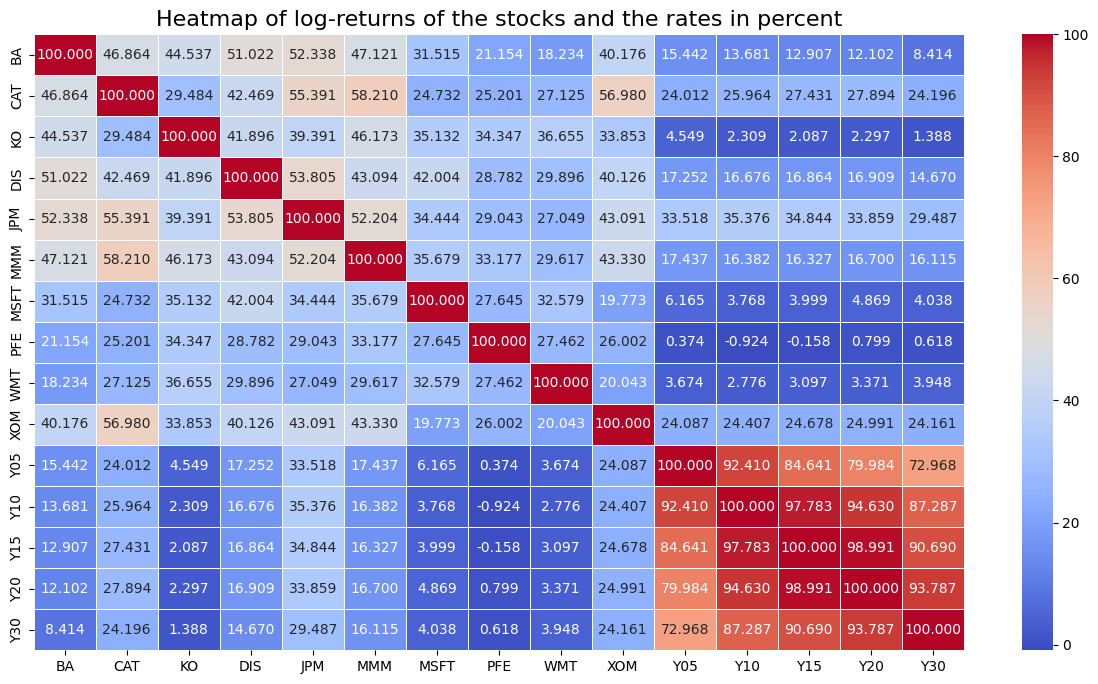

In [21]:
## c
AllAssetsLR= np.log(AllAssetsDf).diff().dropna()

corMat = AllAssetsLR.corr()*100
plt.figure(figsize=(15, 8))

sns.heatmap(corMat, annot=True, fmt=".3f",cmap='coolwarm', linewidths=0.5, linecolor='white');
plt.title('Heatmap of log-returns of the stocks and the rates in percent', fontsize=16);


## 2. VAR(1)-model 
Estimate a VAR(1)-model for the market. 
- a) Estimate the parameters (include them in the report) and check whether the model is stable or not 
(this check should also be detailed in the report). 
- b) Calculate the volatilities of the VAR-residuals and include them in the report. 
- c) Simulate 5000 scenarios with 480 weekly time steps for all assets and plot the price (or interest rate) 
percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and Walmart and the 5- and 
30-year interest rates. 
A total of four plots. Also list these percentiles, for the time periods 240 and 
480, in two tables with the percentiles in the horizontal direction and the stocks and interest rates in 
the vertical direction.

In [6]:
# a)
oneVec = np.ones((AllAssetsLR.shape[0],1))
M = np.concatenate((oneVec, AllAssetsLR.values), axis=1)[1:-1,]
Y = AllAssetsLR.values[2:,:]

a = np.linalg.inv(M.T @ M) @ M.T @ Y

A1 = a[1:,:]
A0 = a[0,:]

e,v = np.linalg.eig(A1)

LargestAbsEigenvalue = max(abs(e))

stableTest = LargestAbsEigenvalue < 1
print(f'The largest absolute eigenvalue is: {LargestAbsEigenvalue}')
print(f'Is the model stable? : {stableTest} ')

The largest absolute eigenvalue is: 0.26346317555787585
Is the model stable? : True 


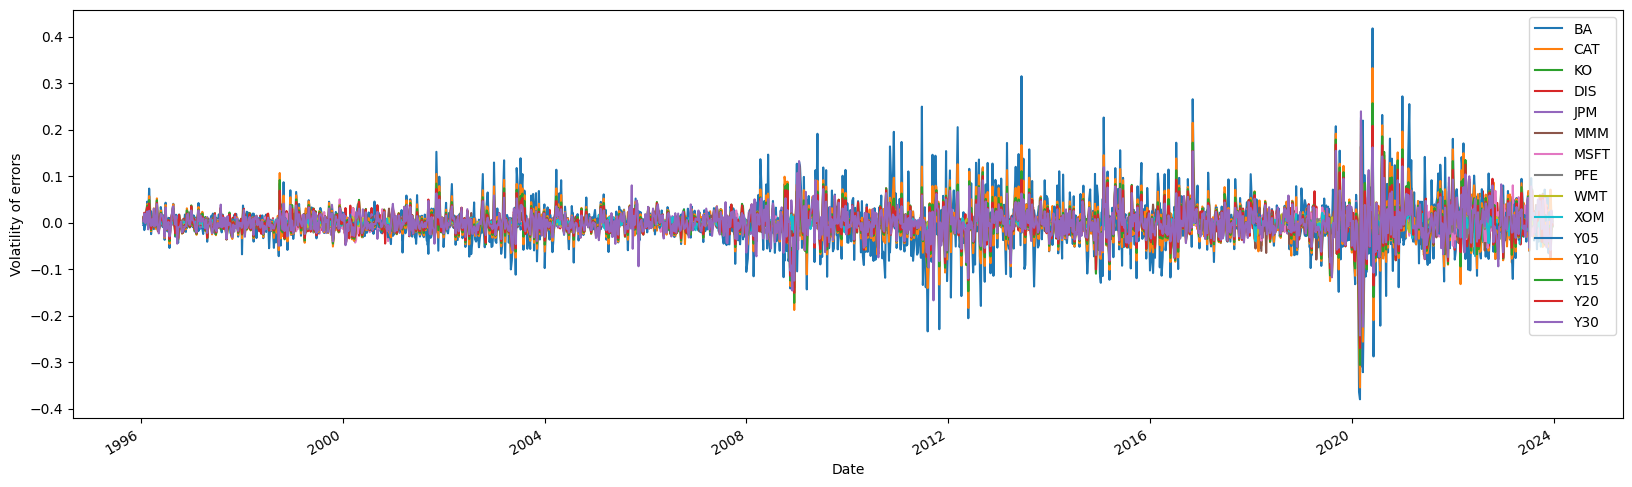

In [7]:
# b)

error = Y - M@a
errorVolatility = np.std(error, axis=0)


PlotVolatilityDF = pd.DataFrame(columns=AllAssetsLR.columns, data=error,index=AllAssetsDf.index[1:-1])
PlotVolatilityDF.plot(figsize=(20,6), ylabel='Volatility of errors');


In [8]:
VolDF = pd.DataFrame(columns=AllAssetsLR.columns)
VolDF.loc['Weekly Volatility'] = errorVolatility
VolDF

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
Weekly Volatility,0.027614,0.016692,0.006152,0.013737,0.013382,0.012084,0.012419,0.005727,0.005055,0.010451,0.06102,0.045657,0.038635,0.034968,0.033677


In [9]:
def VAR1Simulator(Y0, epsilon, A0, A1):
  simulations = epsilon.shape[0]
  numberOfStocks = epsilon.shape[1]
  timeSteps = epsilon.shape[2]

  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  Y = np.zeros((simulations, numberOfStocks, timeSteps + 1 ))
  Y[0, :, 0] = Y0
  for i in range(simulations):
    for t in range(1, timeSteps + 1):
          Y[i, :, t] = A0 + A1 @ Y[i, :, t-1] + epsilon[i, :, t-1]
  return Y

In [10]:
# c)

simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)

covMat = AllAssetsLR.cov()

choleskyMatrix = np.linalg.cholesky(covMat)

# Generate random number cube where depth is simulations, height is stocks, width is time steps
Z = np.random.standard_normal((simulations, numberOfStocks,  weeklyTimestep))
X = choleskyMatrix@Z

Y0 = AllAssetsLR.iloc[-1:].values

simulatedLR = VAR1Simulator(Y0, X, A0, A1)


In [39]:
sumLogReturns = np.cumsum(simulatedLR, axis=2)
initialPrice = AllAssetsDf.iloc[-1,].values
flattenedInitialPrice = initialPrice.flatten()
initialPriceMatrix = np.tile(flattenedInitialPrice, (5000, 480, 1)).transpose(0, 2, 1)
simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, 1:])

quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

catepillarPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentile[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        walmartPercentile[i, j] = np.quantile(simulatedPrices[:, 8, i], quantileValues[j])
        fiveYearPercentile[i, j] = np.quantile(simulatedPrices[:, 10, i], quantileValues[j])
        thirtyYearPercentile[i, j] = np.quantile(simulatedPrices[:, 14, i], quantileValues[j])


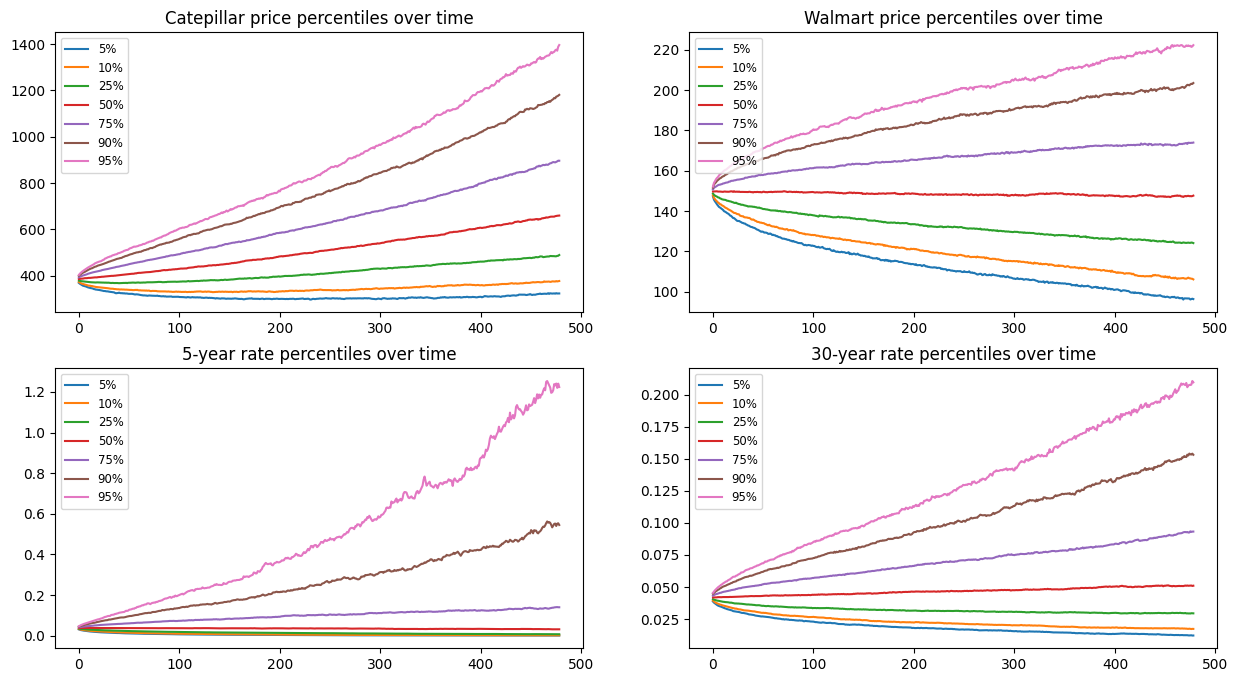

In [40]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, label in enumerate(percentiles):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label)

ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label)

ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize = 'small')

plt.show()

In [13]:
fullTableDf = pd.DataFrame(columns=percentiles)
fullTableDf.loc['Catepillar'] = catepillarPercentile[479,:]
fullTableDf.loc['Walmart'] = walmartPercentile[479,:]
fullTableDf.loc['5-year rate'] = fiveYearPercentile[479,:]
fullTableDf.loc['30-year rate'] = thirtyYearPercentile[479,:]

title = "                           Price and Rate Percentiles for 480 weeks"

print(title)
fullTableDf

                           Price and Rate Percentiles for 480 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,323.400871,377.089043,489.311134,659.639483,896.265473,1180.615915,1395.786635
Walmart,96.298492,106.069698,124.095943,147.647510,173.991956,203.564594,222.363788
5-year rate,0.000898,0.001985,0.007319,0.031636,0.140131,0.545082,1.223947
30-year rate,0.012176,0.017322,0.029455,0.050977,0.093189,0.153033,0.209498


In [14]:
halfTableDf = pd.DataFrame(columns=percentiles)
halfTableDf.loc['Catepillar'] = catepillarPercentile[239,:]
halfTableDf.loc['Walmart'] = walmartPercentile[239,:]
halfTableDf.loc['5-year rate'] = fiveYearPercentile[239,:]
halfTableDf.loc['30-year rate'] = thirtyYearPercentile[239,:]

title = "                           Price and Rate Percentiles for 240 weeks"

print(title)
halfTableDf

                           Price and Rate Percentiles for 240 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,300.429060,338.946405,407.352215,503.934526,618.880021,749.937596,834.461686
Walmart,110.500230,118.293830,131.935913,148.117342,166.896353,186.397633,199.274392
5-year rate,0.002559,0.004708,0.012857,0.036042,0.102335,0.249917,0.439991
30-year rate,0.017357,0.021500,0.031301,0.046837,0.069616,0.099774,0.123948


## 3. Historical simulation 
Use basic historical simulation to simulate 5000 scenarios with 480 weekly time steps for all assets and plot 
the price (or interest rate) percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and 
Walmart and the 5- and 30-year interest rates. A total of four plots. Also list these percentiles, for the time 
periods 240 and 480, in two tables with the percentiles in the horizontal direction and the stocks and interest 
rates in the vertical direction. Plot the percentiles (as dotted lines) in the same plot as the VAR(1)-percentiles. 

In [43]:
sims = 5000
weeks = 480
indexList = [1,8,10,14]

simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)


StocksOfInterest = AllAssetsLR.iloc[:,indexList]

arrays = []

for _ in range(weeks):
    sampled_df = StocksOfInterest.sample(n=sims, replace=True).to_numpy()
    arrays.append(sampled_df)


arrays_3d = np.transpose(np.array(arrays), (1,2,0))

quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]


sumLogReturns = np.cumsum(arrays_3d, axis=2)
initialPrice = AllAssetsDf.iloc[-1,[1,8,10,14]].values
flattenedInitialPrice = initialPrice.flatten()
initialPriceMatrix = np.tile(flattenedInitialPrice, (5000, 480, 1)).transpose(0, 2, 1)
simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, :])



catepillarPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentile[i, j] = np.quantile(simulatedPrices[:, 0, i], quantileValues[j])
        walmartPercentile[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        fiveYearPercentile[i, j] = np.quantile(simulatedPrices[:, 2, i], quantileValues[j])
        thirtyYearPercentile[i, j] = np.quantile(simulatedPrices[:, 3, i], quantileValues[j])





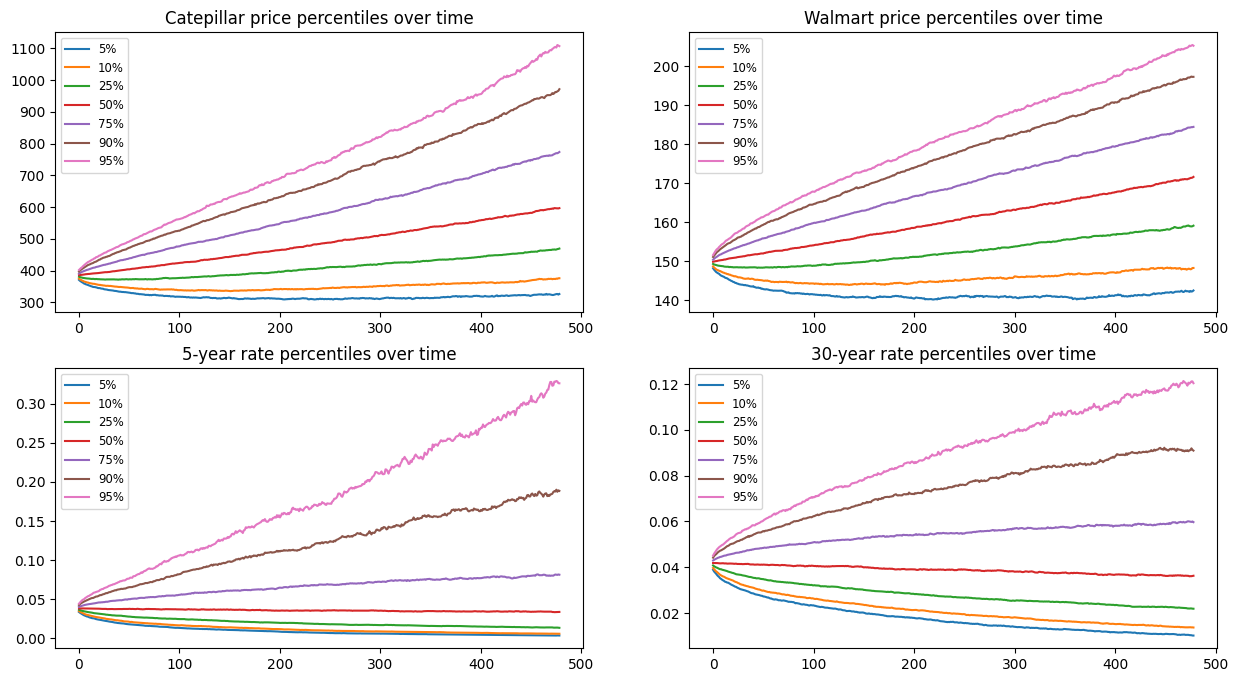

In [44]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, label in enumerate(percentiles):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label)

ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label)

ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize = 'small')

plt.show()

In [45]:
fullTableDf = pd.DataFrame(columns=percentiles)
fullTableDf.loc['Catepillar'] = catepillarPercentile[479,:]
fullTableDf.loc['Walmart'] = walmartPercentile[479,:]
fullTableDf.loc['5-year rate'] = fiveYearPercentile[479,:]
fullTableDf.loc['30-year rate'] = thirtyYearPercentile[479,:]

title = "                           Price and Rate Percentiles for 480 weeks"

print(title)
fullTableDf

                           Price and Rate Percentiles for 480 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,326.311658,376.011164,469.415116,596.746723,773.559540,971.306625,1106.919124
Walmart,142.429260,148.205979,159.059864,171.572661,184.405973,197.246568,205.234282
5-year rate,0.003466,0.005704,0.013306,0.033633,0.081269,0.188568,0.326219
30-year rate,0.010159,0.013676,0.021871,0.036266,0.059688,0.090926,0.120351


In [46]:
halfTableDf = pd.DataFrame(columns=percentiles)
halfTableDf.loc['Catepillar'] = catepillarPercentile[239,:]
halfTableDf.loc['Walmart'] = walmartPercentile[239,:]
halfTableDf.loc['5-year rate'] = fiveYearPercentile[239,:]
halfTableDf.loc['30-year rate'] = thirtyYearPercentile[239,:]

title = "                           Price and Rate Percentiles for 240 weeks"

print(title)
halfTableDf

                           Price and Rate Percentiles for 240 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,309.783076,342.109067,406.671702,483.556110,574.858988,672.052017,740.025573
Walmart,140.680787,144.882605,152.037737,160.228180,168.751854,177.444218,182.493560
5-year rate,0.007114,0.010096,0.018412,0.035541,0.067956,0.121444,0.169697
30-year rate,0.016116,0.019703,0.027018,0.038953,0.054778,0.074939,0.091374


## 4. VAR(1)-DCC-model 
Estimate a VAR(1)-DCC-model for the market 
- a) Plot the ACF, for lags 1 to 50, for the (weekly) residuals and square residuals of the VAR-model, for 
Caterpillar and the 5-year interest rate.  
- b) Estimate the DCC-model and include the DCC-parameters in the report: delta, gamma, the R-matrix 
and the GARCH(1,1)-parameters as a 15*3-matrix. 
- c) Do 2.c) again and plot the price (or interest rate) percentiles (as dashed lines) in the same plot as the 
VAR(1)- and HS-percentiles 


Discussion: What does a) tell you?  

In [15]:
def AutoCorrelationFunction(data, lags, plot = True):
    returnValues = np.zeros(lags)

    for i in range(lags):
        original = data[0:-(1+i)]
        lagged = data[i:-1]
        meanValue = np.mean(original)
        variance = np.var(original)
        
        returnValues[i] = (1/len(original) * ((original - meanValue) @ (lagged - meanValue).T) )/variance
    
    return returnValues

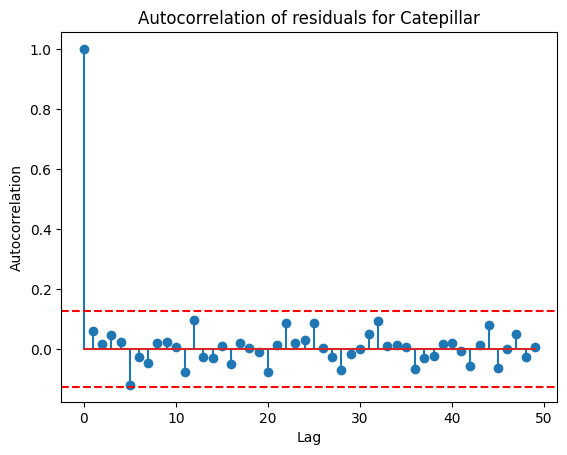

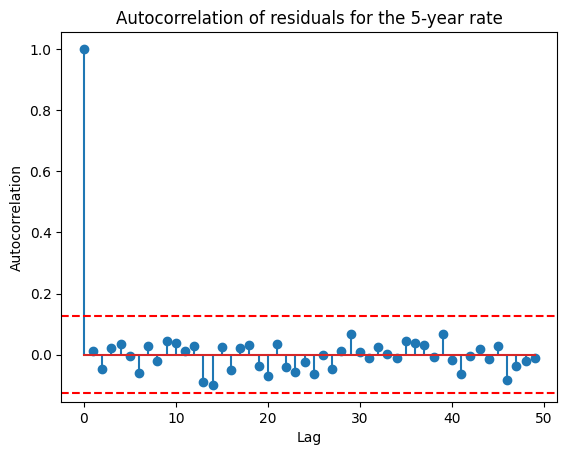

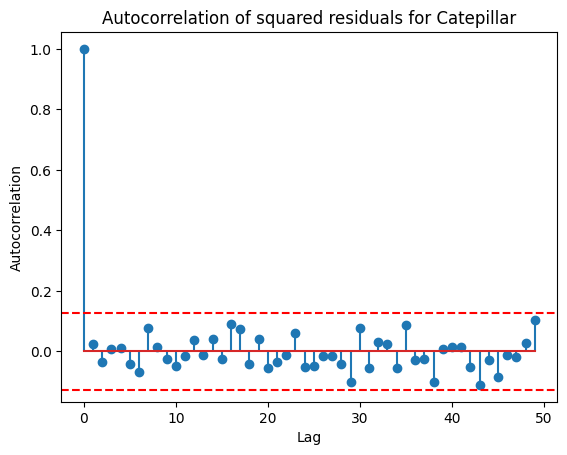

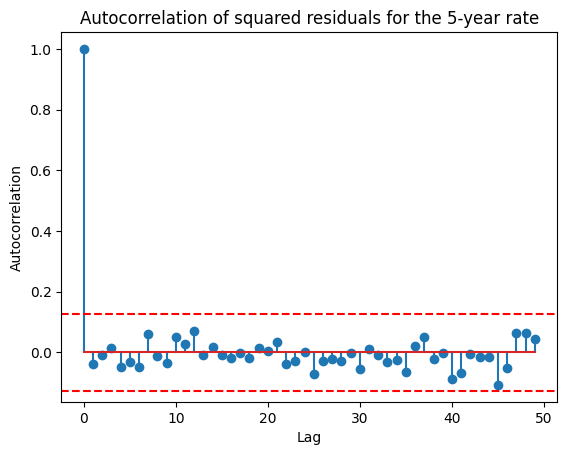

In [16]:
lags = 50

residuals = np.mean(X, axis=0)
squaredResiduals = residuals**2

ACFCatepillarResiduals = AutoCorrelationFunction(residuals[1,:].T, lags)
ACFfiveYearResiduals = AutoCorrelationFunction(residuals[10,:].T, lags)

ACFCatepillarSquareResiduals = AutoCorrelationFunction(squaredResiduals[1,:].T, lags)
ACFfiveYearSsquareResiduals = AutoCorrelationFunction(squaredResiduals[10,:].T, lags)

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(residuals[1,:]))
fig, ax = plt.subplots()
ax.stem(ACFCatepillarResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of residuals for Catepillar')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(residuals[1,:]))
fig, ax = plt.subplots()
ax.stem(ACFfiveYearResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of residuals for the 5-year rate')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(residuals[1,:]))
fig, ax = plt.subplots()
ax.stem(ACFCatepillarSquareResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of squared residuals for Catepillar')
plt.show()

conficenceBound = np.sqrt(2)*1.96 / np.sqrt(len(residuals[1,:]))
fig, ax = plt.subplots()
ax.stem(ACFfiveYearSsquareResiduals)
ax.axhline(y=conficenceBound, color='r', linestyle='--')
ax.axhline(y=-conficenceBound, color='r', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation of squared residuals for the 5-year rate')
plt.show()


In [17]:
## Parameter estimation using Scipy
def likelihoodFunction( parameters, data):
    omega = parameters[0]
    alpha = parameters[1]
    beta = parameters[2]
    initialVolatility = np.std(data) 

    volatilityVector = np.zeros(len(data))
    volatilityVector[0] = initialVolatility
    terms = np.zeros(len(data)-1)

    for i in range(1, len(data)):
        volatilityVector[i] = np.sqrt(omega + alpha * float(data[i-1])  + beta * volatilityVector[i-1] ** 2)
        terms[i-1] = np.log(volatilityVector[i] ** 2) + float(data[i]) / (volatilityVector[i] ** 2)
        
    likelihood = -1/2 * (sum(terms))
    return -likelihood



In [18]:
def GARCHVolatilityEstimator(data, omega, alpha, beta):
    volatilityEstimateGARCH = np.zeros(data.shape[0])
    initialVolatility = np.sqrt(np.mean(data))
    volatilityEstimateGARCH[0] = initialVolatility 

    for i in range(1, len(volatilityEstimateGARCH)):  # Start from 1 to avoid reassigning the first value
        volatilityEstimateGARCH[i] = np.sqrt(omega + alpha * data[i-1] + beta * (initialVolatility ** 2))
        initialVolatility = volatilityEstimateGARCH[i]

    return volatilityEstimateGARCH

In [19]:
logReturns = np.mean(simulatedLR,axis=0)
H = np.zeros_like(logReturns)
garchParameters = np.zeros((15, 3))
volatilityEstimateGARCH = np.zeros_like(logReturns).T

epsilon = 1e-10
constraints = [{'type': 'ineq', 'fun': lambda parameters: -(parameters[1] +parameters[2] -1 -epsilon)}]
bounds = [(0 + epsilon, None), (0 + epsilon, None), (0 + epsilon, None)] #omega, alpha, beta

x0 = [0.05, 0.6, 0.5]

for i in range(0,len(logReturns[:,1])):
    H[i,:] = logReturns[i,:] - np.mean(logReturns[i,:])
    multipliedSquareReturns = 100*H[i,:]**2
    
    objectiveFixDF = partial(likelihoodFunction, data = multipliedSquareReturns)
    result = minimize(objectiveFixDF, x0, method='SLSQP', bounds=bounds, constraints=constraints )
    garchParameters[i,:] = result.x

    volatilityEstimateGARCH[:, i] = GARCHVolatilityEstimator((H[i,:]**2), (garchParameters[i,0]/(100**2)), garchParameters[i,1], garchParameters[i,2])

    print("Optimal parameters:", result.x)
    print("Function value at the optimum:", result.fun)


Optimal parameters: [4.52930215e-05 1.00000008e-10 1.00000000e-10]
Function value at the optimum: -2281.801557368547
Optimal parameters: [1.06734926e-05 5.06786957e-01 1.06050252e-06]
Function value at the optimum: -2555.2740685239382
Optimal parameters: [4.08494575e-05 4.26210342e-01 4.05655159e-06]
Function value at the optimum: -2314.0211882559183
Optimal parameters: [5.06336820e-05 1.00000001e-10 7.43734744e-02]
Function value at the optimum: -2115.283955463579
Optimal parameters: [3.26058561e-05 4.72617340e-01 2.65133094e-06]
Function value at the optimum: -2289.6766172515663


C:\Users\Bolli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\Bolli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\Bolli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimal parameters: [3.81422071e-05 1.09582327e-02 6.83491874e-02]
Function value at the optimum: -2181.999053209092
Optimal parameters: [2.34446424e-05 5.20650330e-01 2.32778606e-06]
Function value at the optimum: -2499.82185812737
Optimal parameters: [3.86113398e-05 1.00000397e-10 1.00000000e-10]
Function value at the optimum: -2199.9512142793133
Optimal parameters: [4.48444333e-05 5.69818115e-01 4.45220991e-06]
Function value at the optimum: -2354.445684711774
Optimal parameters: [1.69463354e-05 4.92250671e-01 1.68281657e-06]
Function value at the optimum: -2451.3004570082144
Optimal parameters: [0.02657298 0.3188646  0.26572058]
Function value at the optimum: -795.4502710723202
Optimal parameters: [0.02391525 0.28697814 0.23914849]
Function value at the optimum: -821.6863166473563
Optimal parameters: [1.33153859e-03 2.74847336e-02 1.00000000e-10]
Function value at the optimum: -1342.6006733810507
Optimal parameters: [4.66153545e-04 9.62490492e-02 1.00000000e-10]
Function value at t

## 5. Explore the data 
You can do this part of the assignment in Excel (in that case submit also the Excel file).  
- a) Plot the average, over the five years of data, of the mean population for each age for both men and 
women in the same figure. 
- b) Plot the average, over the five years of data, of the number of deaths for each age for both men and 
women in the same figure.   


Discussion: What do these plots tell you? 

In [20]:
menDeathsDF = pd.read_excel('deathsMen.xlsx').dropna()
womenDeathsDF = pd.read_excel('deathsWomen.xlsx').dropna()
menPopulationDF = pd.read_excel('populationMen.xlsx').dropna()
womenPopulationDF = pd.read_excel('populationWomen.xlsx').dropna()

menDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
menDeathsDF.drop(columns='Unnamed: 1', inplace = True)
womenDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
womenDeathsDF.drop(columns='Unnamed: 1', inplace = True)

menPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
menPopulationDF.drop(columns='Unnamed: 1', inplace = True)
womenPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
womenPopulationDF.drop(columns='Unnamed: 1', inplace = True)



ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

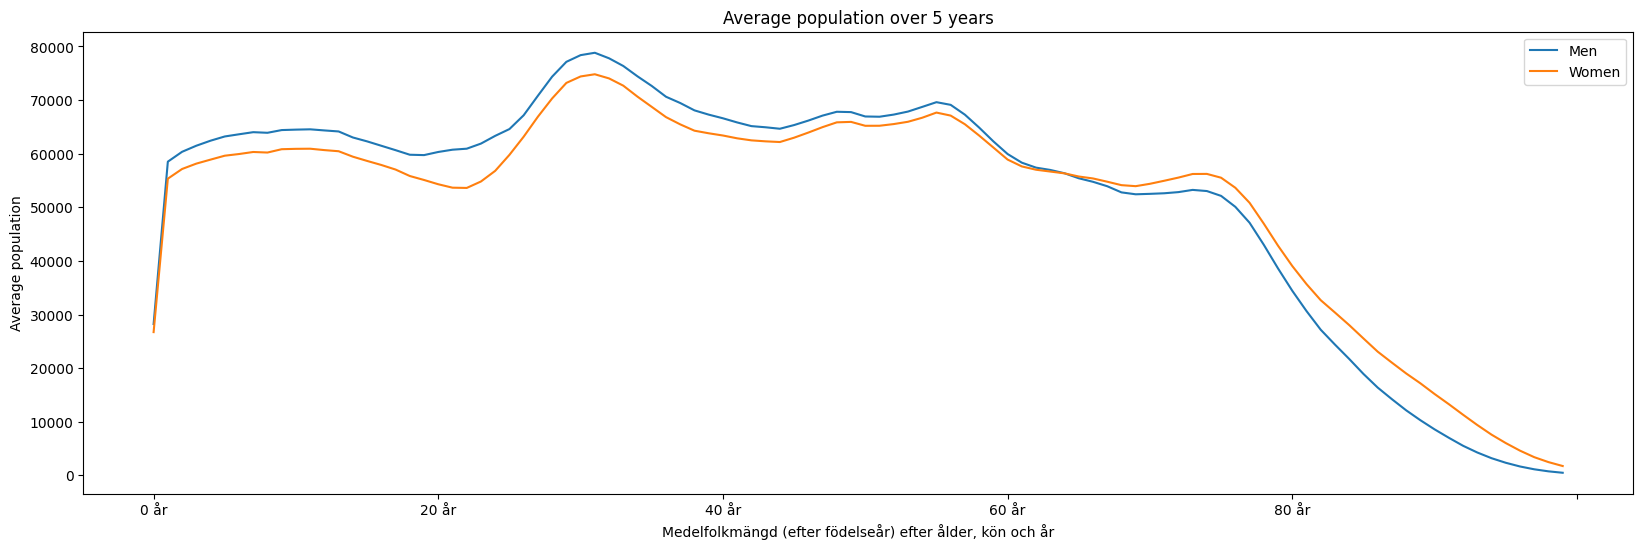

In [21]:
np.mean(menPopulationDF.iloc[:-1,], axis=1).plot(figsize=(20,6),title='Average population over 5 years', ylabel='Average population', label='Men');
np.mean(womenPopulationDF.iloc[:-1,], axis=1).plot(figsize=(20,6), ylabel='Average population', label='Women');
plt.legend();

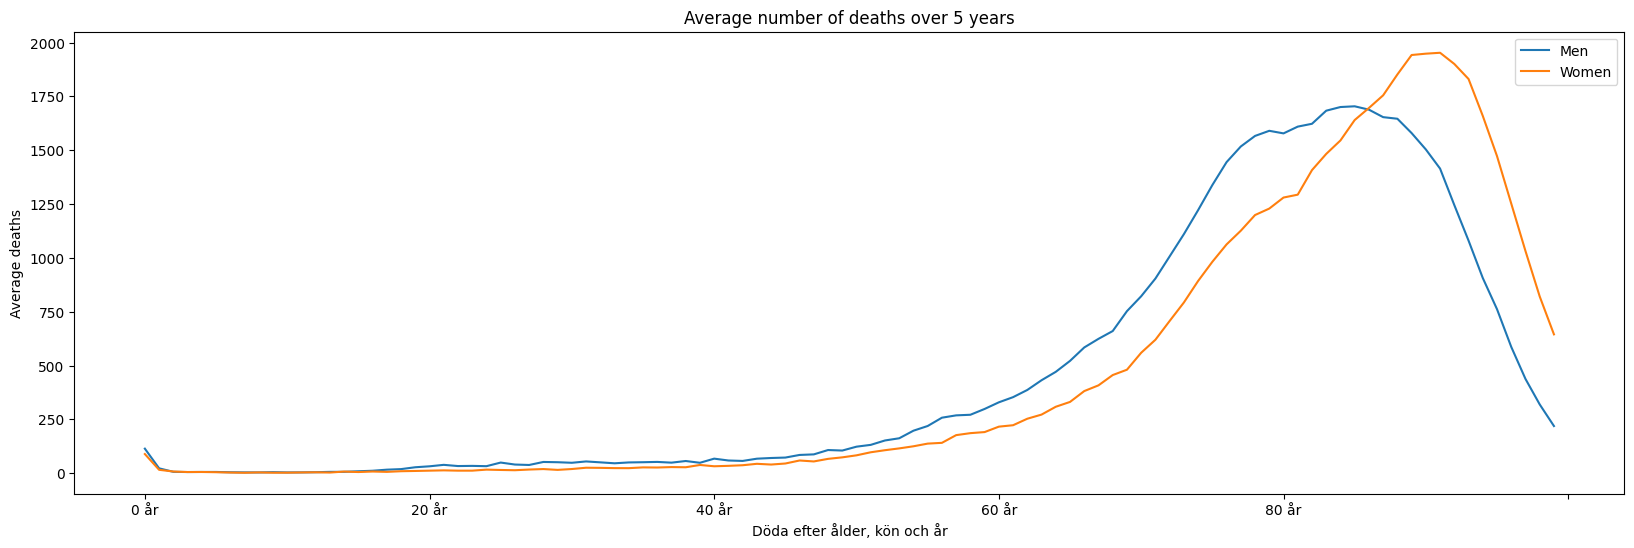

In [22]:
averageDeathsMen = np.mean(menDeathsDF.iloc[:-1,], axis=1)
averageDeathsWomen = np.mean(womenDeathsDF.iloc[:-1,], axis=1)
averageDeathsMen.plot(figsize=(20,6), title='Average number of deaths over 5 years', ylabel='Average deaths', label='Men');
averageDeathsWomen.plot(figsize=(20,6), ylabel='Average deaths', label='Women');
plt.legend();

## 6. Mortality estimation 
This task is also suitable for Excel, where you can use Solver to find the Makeham parameters. 
- a) Estimate the force of mortality for men and women separately using the SCB-data and plot these 
estimates in the same figure. Do this for ages 20 – 99 and use data for all five years for a more stable 
estimate. 
- b) Fit Makeham functions using only force of mortality estimates for ages 20 – 90 from above. Then plot 
the estimated forces of mortality, for ages 20 – 99, together with the Makeham functions in the same 
figure (both men and women). Include the parameters in the report. 
- c) Plot the survival functions for men and women, for ages 0 – 105, in the same figure (but not the same 
as in b).  
- d) Calculate life expectancy for both men and women, according to the lifetime distributions given by the 
Makeham functions. 

In [29]:
# a)

DMen = menDeathsDF.iloc[:-1,].sum(axis=1)
DWomen = womenDeathsDF.iloc[:-1,].sum(axis=1)

NMen = menPopulationDF.iloc[:-1,].sum(axis=1)
NWomen = womenPopulationDF.iloc[:-1,].sum(axis=1)

muMen = DMen/NMen
muWomen = DWomen/NWomen

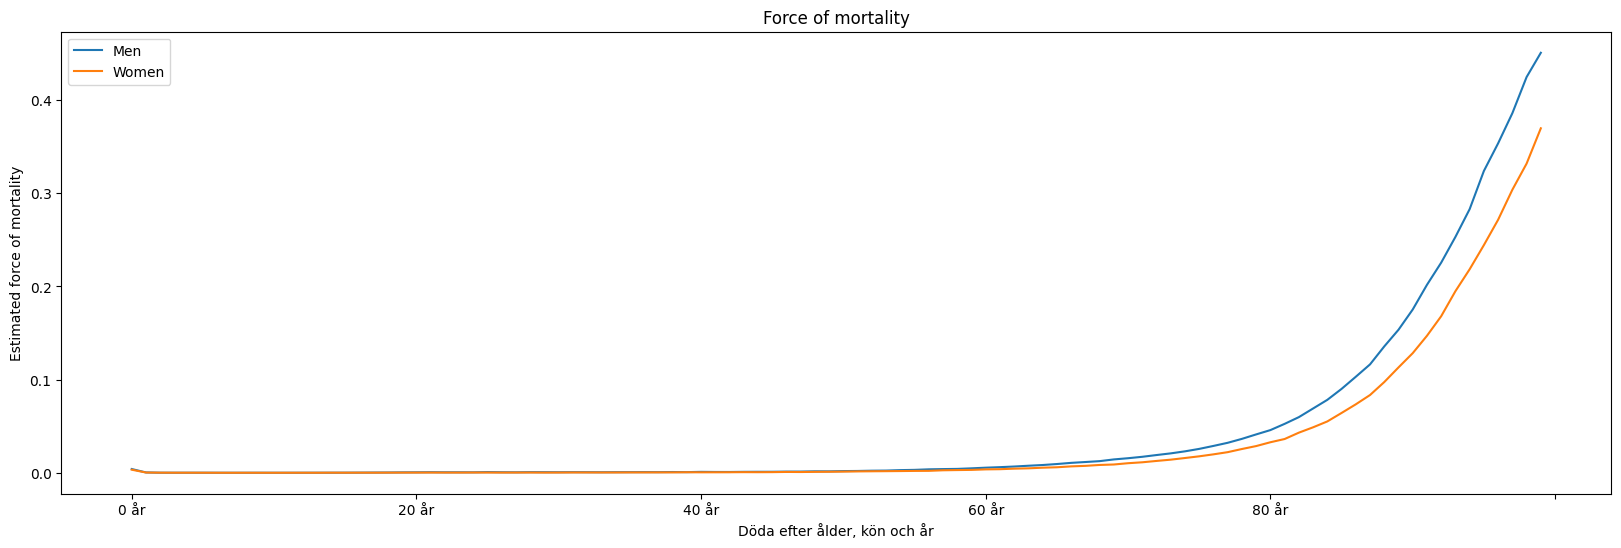

In [30]:
muMen.plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen.plot(figsize=(20,6), label='Women');
plt.legend();

In [ ]:
# b)
def MakehamParameters(mu, )
    m = mu.sum(axis=0) 

## 7. 1st order payout and reserve 
Calculate the guaranteed payout amount and project the 1st order reserve for the policy.  
- a) Determine the yearly payout amount, b.  
- b) Plot the evolution of the reserve 30 years into the future.  
- c) Include a table with the value of the reserve for every 5 years.  